In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
# I was getting a ModuleNotFoundError, and I discovered that the cwd (current working directory) was
#   '<Github Home>/market-modeling/examples/' but it needs to be '<Github Home>/market-modeling/'
# The following code will add the cwd's parent directory to the path Python uses to search for packages
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import os
from datetime import datetime

from models.gbm_models.Models import IndependentModel
from markets.Markets import Market
from assets.Assets import BaseAsset
from metrics.Metrics import VarType, TimeseriesMetric

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
DEBUG = False
DATA_DIR = '../data'
MARKET_NAME = 'popular_stocks'
TS_DIR = 'growth_timeseries'

In [5]:
asset_list = []
asset_metadata = pd.read_csv(os.path.join(DATA_DIR, MARKET_NAME, 'asset_metadata.tsv'), sep='\t')

for i, row in asset_metadata.iterrows():
  if DEBUG:
    if i == 5:
      break
  
  asset_ts = pd.read_csv(
    os.path.join(DATA_DIR, MARKET_NAME, TS_DIR, f"{row['id']}.csv"),
    parse_dates=['date'],
    dtype={'price' : np.float32}
  )
  
  asset = BaseAsset(
    row['name'],
    row['id'],
    {
      'signal': TimeseriesMetric(asset_ts['date'], asset_ts['price'], VarType.QUANTITATIVE)
    }
  )
  asset_list.append(asset)


market = Market(asset_list, MARKET_NAME)
indep_model = IndependentModel(market)

In [6]:
market.align_timeseries()
indep_model.estimate_parameters()

In [7]:
df_results = pd.DataFrame({
  'id' : market.xarray_ds.ID.values,
  'drifts' : indep_model.drifts,
  'vols' : indep_model.vols
})

df_results

,id,drifts,vols
0,AAPL,0.000968,0.000309
1,AMGN,0.000361,0.000224
2,AMZN,0.000647,0.000408
3,AXP,0.000728,0.000423
4,BA,0.000010,0.000758
5,CAT,0.000734,0.000340
6,CRM,0.000627,0.000512
7,CSCO,0.000263,0.000266
8,CVX,0.000409,0.000376
9,DIS,0.000208,0.000368


In [8]:
dates_to_sim = pd.to_datetime(
  pd.Series(['12-16-2024', '12-18-2024', '12-20-2024', '12-23-2024'], name='dates'),
  format='%m-%d-%Y'
)

prev_time, prev_state = market.get_market_state_before_date(min(dates_to_sim))
prev_signals = prev_state.sel(variable='signal').to_numpy()

sim_dates = pd.concat((pd.Series([prev_time], name='dates'), dates_to_sim))

In [9]:
sim_res = indep_model.simulate(prev_signals, sim_dates, num_sims=20)
sim_counterfact = indep_model.simulate(prev_signals, sim_dates, 1, add_BM=False)

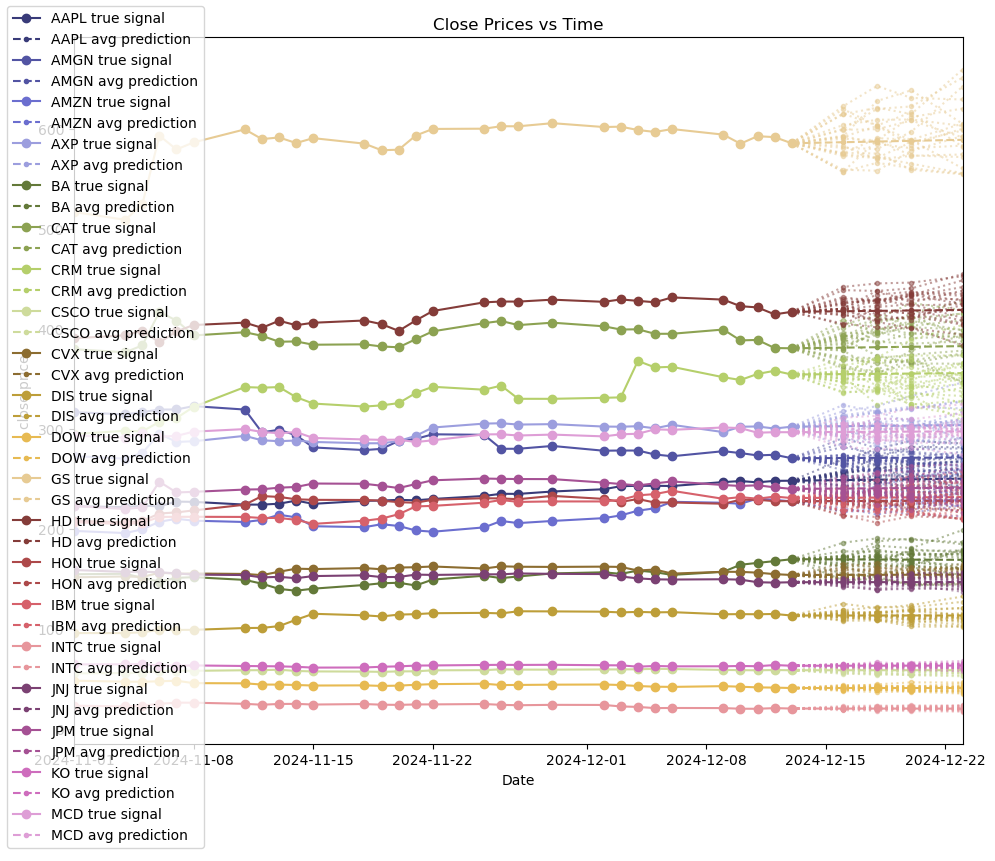

In [11]:
colorscheme = mpl.colormaps['tab20b']
fig, ax = plt.subplots(figsize=(10,8))

xarr = market.get_dataarray()

for i in range(colorscheme.N):
  asset_i_id = xarr.isel(ID=i)['ID'].values
  # plot true observations
  ax.plot(
    xarr.time, xarr.sel(ID=asset_i_id, variable='signal'),
    '-o', color=colorscheme.colors[i % colorscheme.N],
    label=f'{asset_i_id} true signal'
  )
  # plot simulated predictions w/o GBM
  ax.plot(
    sim_dates, sim_counterfact[0, i, :],
    color=colorscheme.colors[i % colorscheme.N], marker='.', linestyle='dashed',
    label=f'{asset_i_id} avg prediction'
  )
	# plot simulated predictions w/ GBM
  for j_sim in range(sim_res.shape[0]):
    ax.plot(
      sim_dates, sim_res[j_sim, i, :],
      alpha=0.5, color=colorscheme.colors[i % colorscheme.N], linestyle='dotted', marker='.'
    )
ax.set_xlim([datetime(2024, 11, 1), sim_dates.max()])
ax.set(xlabel='Date', ylabel='close price', title='Close Prices vs Time')
fig.tight_layout()
fig.legend(loc=2);